In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = "/content/drive/MyDrive/panorama-stitching-classcial-and-Deep-Learning-master"

In [ ]:
phase1 = "/content/drive/MyDrive/panorama-stitching-classcial-and-Deep-Learning-master/Phase1"

In [ ]:
phase2 = "/content/drive/MyDrive/panorama-stitching-classcial-and-Deep-Learning-master/Phase2"

In [ ]:
import numpy as np
import cv2

In [ ]:
im1_path = '/content/drive/MyDrive/panorama-stitching-classcial-and-Deep-Learning-master/Phase1/Data/Train/Set1/1.jpg'
im2_path = '/content/drive/MyDrive/panorama-stitching-classcial-and-Deep-Learning-master/Phase1/Data/Train/Set1/2.jpg'
im3_path = '/content/drive/MyDrive/panorama-stitching-classcial-and-Deep-Learning-master/Phase1/Data/Train/Set1/3.jpg'

    # im1_path = '../Data/Train/Set2/1.jpg'
    # im2_path = '../Data/Train/Set2/2.jpg'
    # im3_path = '../Data/Train/Set2/3.jpg'

    # im1_path = '../Data/Train/Set3/1.jpg'
    # im2_path = '../Data/Train/Set3/2.jpg'
    # im3_path = '../Data/Train/Set3/3.jpg'

    # im1_path = '../Data/Train/CustomSet1/custom1.jpg'
    # im2_path = '../Data/Train/CustomSet1/custom2.jpg'
    # im3_path = '../Data/Train/CustomSet1/custom3.jpg'

image1 = cv2.imread(im1_path)                      # load from image file
image2 = cv2.imread(im2_path)
image3 = cv2.imread(im3_path)

image1_grey = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)          # greyscale image, less data to work on
# image1_grey = np.float32(image1_grey)                           # convert to numpy array
image2_grey = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    # image2_grey = np.float32(image2_grey)
image3_grey = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)


In [ ]:
def ANMS(image, corners, tolerance, num_best_corners):
    """
    ANMS algorithm for filtering out detected corners of the image
    image: TODO remove this
    corners: output of cornerHarris function on the image
    num_best_corners: the number of best ranking corners to keep in the filtered list
    returns a num_best corners by 3 array, [Y, X, ANMS ranking]
    """

    # All local maxima (corners) of 'image' found using Corner Harris function, passed in as 'corners'
    # tolerance is how much of the highest scoring pixels to keep, lower keep more, higher keep less

    # Step 1: Locate all x y coordinates of maxima above a certain score, tune the tolerance parameter

    corners_boolean = corners > tolerance * corners.max()           # 'boolean image' for locating corner coordinates
    coordinates_tuple = np.nonzero(corners_boolean)                 # returns tuple of indexes where not false or 0
    corners_locations = np.asarray(coordinates_tuple)               # convert to numpy array
    corners_locations = np.transpose(corners_locations)             # transpose for better syntax later
    num_corners = len(corners_locations)
    print('Num of corners = ' + str(num_corners))                   # print for debugging

    # Step 2: Rank the corners by the Euclidean distance to their closest neighboring corner using ANMS
    r = np.ones((num_corners, 1)) * np.inf              # initialize an array of infinity values, num_corners x 1
    ED = np.inf                                         # initialize the current Euclidian distance

    # ANMS algorithm implementation, compare each corner to every other corner, computationally expensive
    for i in range(num_corners):
        for j in range(num_corners):
            x_i = corners_locations[i][1]                     # get the x and y pixel coordinates of the corners
            y_i = corners_locations[i][0]                     # i = y pixel coordinate
            x_j = corners_locations[j][1]                     # j = x pixel coordinate
            y_j = corners_locations[j][0]

            C_i = corners[y_i, x_i]                           # get the corner scores
            C_j = corners[y_j, x_j]

            if C_j > C_i:                                     # if it's a higher-scoring corner than our ith one
                ED = ((x_j - x_i) ** 2) + ((y_j - y_i) ** 2)  # (xj - xi)^2 + (yj - yi)^2

            if ED < r[i]:                                     # if less than the current Euclidean distance
                r[i] = ED                                     # then save it as the new lowest

    # Making a num_corners x 3 array, storing each corner's coordinates and ANMS ranking
    corners_locations_np = np.array(corners_locations)                      # convert to numpy array
    corners_y, corners_x = np.split(corners_locations_np, 2, axis=1)        # split into x and y coordinates
    corners_ranked = np.concatenate((corners_y, corners_x, r), axis=1)      # combine x and y with their rankings

    # Sort the array from highest ranked corner coordinates to lowest, [:, 2] because ranking is in the 3rd column
    corners_sorted = corners_ranked[corners_ranked[:, 2].argsort()[::-1]]   # [::-1] means iterate through backwards

    if num_best_corners > num_corners:
        num_best_corners = num_corners
    corners_best = corners_sorted[0:num_best_corners, :]                    # keep only N best desired corners

    # Color the corners on the image to visualize
    # for i in range(num_best_corners):
    #     x = int(corners_best[i, 1])
    #     y = int(corners_best[i, 0])
    #     green = [0, 255, 0]                                                # BGR values
    #     image[y, x] = green                                                # color the pixel to visualize

    # Display for testing
    # cv2.imshow('Image window', image)
    # cv2.waitKey(0)      # Don't close the display window

    return corners_best

In [ ]:
def get_features(points_best, grey_image):
    """
    Creating the image feature descriptor array
    points_best: num_points_best x 3 array, [Y, X, ANMS ranking]
    grey_image: the image used to find points_best, must be greyscale
    returns a 64 x 1 x num_points_best array of the corner feature descriptors
    """

    patch_size = 40                                 # size of pixel square to sample a feature on the image
    features = np.array(np.zeros((64, 1)))          # sub-sampled patch array

    grey_image = np.pad(grey_image, int(patch_size), 'constant', constant_values=0)    # pad the image by the patch size

    num_features, cols = points_best.shape

    for i in range(num_features):

        # The coordinates of the corners are now offset by patch_size after the np.pad and must be corrected
        patch_y = points_best[i][0] + patch_size
        patch_x = points_best[i][1] + patch_size

        # Pick out a square patch from the padded image of size patch_size, corner point should be the patch center
        patch = grey_image[int(patch_y - (patch_size / 2)):int(patch_y + (patch_size / 2)),
                int(patch_x - (patch_size / 2)):int(patch_x + (patch_size / 2))]

        patch_blurred = cv2.GaussianBlur(patch, (5, 5), 0)          # apply a blur to smooth the image
        patch_sub_sampled = cv2.resize(patch_blurred, (8, 8))       # sub-sample to a square of size 8

        patch_sub_sampled = patch_sub_sampled.reshape(64, 1)        # reshape to a 64 by 1 array

        # Standardize the vector to have zero mean and variance of 1, removes bias and increase illumination invariance
        patch_sub_sampled = (patch_sub_sampled - np.mean(patch_sub_sampled)) / np.std(patch_sub_sampled)

        features = np.dstack((features, patch_sub_sampled))         # stack the features in sequence depth-wise (axis 3)

    # TODO: save the output as FD.png

    # print(features.shape)
    # print(grey_image)

    # Display for testing
    # cv2.imshow('Image window', patch_blurred)
    # cv2.waitKey(0)      # Don't close the display window

    return features[:, :, 1:]      # discard the first row of zeros, just used to initialize the array


def match_features(features1, features2, corners1, corners2):
    """
    Give the matched feature pairs from the two images
    features1: The array of features in the image returned by get_features
    features2: The array of features in the image returned by get_features
    corners1: The array of best corners in the image returned by ANMS
    corners2: The array of best corners in the image returned by ANMS
    outputs an array of the matched features
    """

    a, b, num_features1 = features1.shape
    c, d, num_features2 = features2.shape
    min_features = int(min(num_features1, num_features2))
    max_features = int(max(num_features1, num_features2))

    tolerance_diff_ratio = 0.7                             # feature similarity tolerance for keeping or rejecting pairs
    match_pairs = []                                       # array to store the final matched pairs

    # Compare all features in the smaller list to every other feature in the larger list
    for i in range(min_features):

        matches = {}    # dictionary for mapping the sum squares differences with the corresponding corner points

        for j in range(max_features):

            feature1 = features1[:, :, i]
            feature2 = features2[:, :, j]
            corner1 = corners1[i, :]
            corner2 = corners2[j, :]

            diff_sum_squares = np.linalg.norm((feature1 - feature2)) ** 2       # sum of squares differences formula
            matches[diff_sum_squares] = [corner1, corner2]

        sorted_matches = sorted(matches)    # sort the dictionary by the sum squares differences

        if sorted_matches[0] / sorted_matches[1] < tolerance_diff_ratio:
            pairs = matches[sorted_matches[0]]
            match_pairs.append(pairs)

    return match_pairs

In [ ]:
def RANSAC(matches):
    """
    Random Sample Consensus algorithm or RANSAC to remove outliers from the matched feature pairs of the images
    matches: the array of best matched feature pairs for two images returned by match_features()
    outputs the modified array of best matches after applying RANSAC and computed homography
    """

    iterations = 10000                              # iterations of RANSAC to attempt unless found enough paris
    tau = 30                                        # threshold of inliers to keep
    num_matches = len(matches)                      # how many pairs were matched
    percent_good_matches = 0.6                      # what percentage of num_matches are enough to stop iterating
    latest_homography = np.zeros((3, 3))            # latest computed pair homography matrix
    maximum = 0

    for index in range(iterations):                 # index iterator variable non-use intentional

        pairs_indices = []                          # array of good matches

        # 1. Select four matched feature pairs from each image at random
        points = [np.random.randint(0, num_matches) for num in range(4)]      # four random points within num_matches

        # The four points which bound the feature, pt from image 1 (index 0) and pt_prime from image 2 (index 1)
        pt_1 = np.flip(matches[points[0]][0][0:2])          # point is [Y, X, rank], thus [0:2] to keep only Y and X
        pt_2 = np.flip(matches[points[1]][0][0:2])          # then flip the order to have a proper [X, Y] point
        pt_3 = np.flip(matches[points[2]][0][0:2])
        pt_4 = np.flip(matches[points[3]][0][0:2])
        pt_prime_1 = np.flip(matches[points[0]][1][0:2])
        pt_prime_2 = np.flip(matches[points[1]][1][0:2])
        pt_prime_3 = np.flip(matches[points[2]][1][0:2])
        pt_prime_4 = np.flip(matches[points[3]][1][0:2])

        pts = np.array([pt_1, pt_2, pt_3, pt_4], np.float32)                                    # float32 for opencv
        pts_prime = np.array([pt_prime_1, pt_prime_2, pt_prime_3, pt_prime_4], np.float32)

        # 2. Compute homography between the random point pairs
        H = cv2.getPerspectiveTransform(pts, pts_prime)

        num_good_matches = 0            # keep track of how many good matches found in the next step

        # 3. Compute inliers or best matches using SSD and threshold, repeat until sufficient matches found
        for i in range(num_matches):

            y_pt = matches[i][0][0]
            x_pt = matches[i][0][1]
            y_pt_prime = matches[i][1][0]
            x_pt_prime = matches[i][1][1]

            pt_prime_i = np.array([x_pt_prime, y_pt_prime])     # convert to numpy array

            pt_i = np.array([x_pt, y_pt, 1])                    # make homogeneous to multiply by H
            H_pt_i = np.matmul(H, pt_i)                         # multiply by H

            if H_pt_i[2] == 0:                                  # prevent divide by zero error
                H_pt_i[2] = 0.0000001
            p_x = H_pt_i[0] / H_pt_i[2]                         # x is now index 0 and y is now index 1
            p_y = H_pt_i[1] / H_pt_i[2]

            H_pt_i = np.array([p_x, p_y], np.float32)
            # H_pt_i = np.float32([point for point in H_pt_i])

            SSD = np.linalg.norm((pt_prime_i - H_pt_i)) ** 2          # sum of squares differences formula
            # print(SSD)

            if SSD < tau:                                             # only include matches under the threshold
                num_good_matches += 1
                pairs_indices.append(i)

        matches_p = []
        matches_prime = []

        if maximum < num_good_matches:
            maximum = num_good_matches

            [matches_p.append([np.flip(matches[ind][0][0:2])]) for ind in pairs_indices]
            [matches_prime.append([np.flip(matches[ind][1][0:2])]) for ind in pairs_indices]
            # print('matches_p: ', matches_p)
            # print('matches_prime: ', matches_prime)

            latest_homography, a = cv2.findHomography(np.float32(matches_p), np.float32(matches_prime))

            if num_good_matches > percent_good_matches * num_matches:       # end if desired matches num were found
                break

    matched_pairs = [matches[i] for i in pairs_indices]         # find the pairs corresponding to the computed indicies

    return latest_homography, matched_pairs

In [ ]:
"""
Corner Detection
Save Corner detection output as corners.png
"""

# Harris corner detector parameters
block_size = 2      # neighborhood size
k_size = 3          # aperture parameter for the Sobel operator
k = 0.05            # Harris detector free parameter from the formula
image1_dst = cv2.cornerHarris(image1_grey, block_size, k_size, k)
image2_dst = cv2.cornerHarris(image2_grey, block_size, k_size, k)
image3_dst = cv2.cornerHarris(image3_grey, block_size, k_size, k)

# dst = cv2.dilate(dst, None)

# Visualizing the corners, threshold for an optimal value depending on the image, higher is less sensitive
tolerance = 0.04  # 0.04
image1_corners = image1.copy()
image2_corners = image2.copy()
image3_corners = image3.copy()
# Color the local maxima (identified corners) from the response map
purple = [255, 0, 255]  # BGR values
image1_corners[image1_dst > tolerance * image1_dst.max()] = purple
image2_corners[image2_dst > tolerance * image2_dst.max()] = purple

# TODO: save the output as corners.png

"""
Perform ANMS: Adaptive Non-Maximal Suppression
Save ANMS output as anms.png
"""
num_best = 100
image1_corners_best = ANMS(image1_corners, image1_dst, tolerance, num_best)
image2_corners_best = ANMS(image2_corners, image2_dst, tolerance, num_best)
image3_corners_best = ANMS(image3_corners, image3_dst, tolerance, num_best)

# Display and save
image1_ANMS = image1.copy()
yellow = [0, 255, 255]
dot_size = 3

for corner in image1_corners_best:                                  # Visualizing the output
    x = int(corner[1])
    y = int(corner[0])
    cv2.circle(image1_ANMS, (x, y), dot_size, yellow, -1)
# TODO save as anms.png
# cv2.imwrite() ...


"""
Feature Descriptors
Save Feature Descriptor output as FD.png
"""
image1_features = get_features(image1_corners_best, image1_grey)
image2_features = get_features(image2_corners_best, image2_grey)
image3_features = get_features(image3_corners_best, image3_grey)
#print(image1_features.shape)

Num of corners = 653
Num of corners = 1204
Num of corners = 933


In [ ]:
"""
Feature Matching
Save Feature Matching output as matching.png
"""

matched_1_2 = match_features(image1_features, image2_features, image1_corners_best, image2_corners_best)
matched_2_3 = match_features(image2_features, image3_features, image2_corners_best, image3_corners_best)

In [ ]:
"""
Refine: RANSAC, Estimate Homography
"""
H_1_2, matched_1_2 = RANSAC(matched_1_2)
H_2_3, matched_2_3 = RANSAC(matched_2_3)

In [ ]:
import matplotlib.pyplot as plt

def visualize_matches(image1, image2, matched_pairs):
    """
    Mark out and draw each matched corner pair on the two images
    image1: first image object
    image2: second image object
    matched_pairs: The array of matched corner points, [num_best_points x 2 x 3]
    """
    import numpy as np

    # Handling the case of a color or greyscale image passed to the visualizer
    if len(image1.shape) == 3:
        height1, width1, depth1 = image1.shape
        height2, width2, depth2 = image2.shape
        shape = (max(height1, height2), width1 + width2, depth1)

    elif len(image1.shape) == 2:
        height1, width1 = image1.shape
        height2, width2 = image2.shape
        shape = (max(height1, height2), width1 + width2)

    image_combined = np.zeros(shape, dtype=image1.dtype)          # blank side-by-side images
    image_combined[0:height1, 0:width1] = image1                    # fill in left side image
    image_combined[0:height1, width1:width1 + width2] = image2      # fill in right side image
    image_12 = image_combined.copy()

    circle_size = 4
    red = [0, 0, 255]
    cyan = [255, 255, 0]
    yellow = [0, 255, 255]

    # Mark each matched corner pair with a circle and draw a line between them
    for i in range(len(matched_pairs)):
        corner1_x = matched_pairs[i][0][1]
        corner1_y = matched_pairs[i][0][0]
        corner2_x = matched_pairs[i][1][1]
        corner2_y = matched_pairs[i][1][0]

        cv2.line(image_12, (int(corner1_x), int(corner1_y)), (int(corner2_x + image1.shape[1]), int(corner2_y)), red, 1)
        cv2.circle(image_12, (int(corner1_x), int(corner1_y)), circle_size, cyan, 1)
        cv2.circle(image_12, (int(corner2_x) + image1.shape[1], int(corner2_y)), circle_size, yellow, 1)

    return image_12

# Example usage
#combined_image = visualize_matches(image1, image2, matched_pairs)
#plt.imshow(combined_image)
#plt.axis('off')
#plt.show()


In [ ]:
visualize_matches(image1, image2, matched_1_2)
visualize_matches(image2, image3, matched_2_3)

array([[[198, 219, 211],
        [198, 219, 211],
        [198, 218, 213],
        ...,
        [123, 146, 154],
        [127, 147, 158],
        [131, 151, 162]],

       [[213, 219, 218],
        [212, 218, 217],
        [212, 218, 217],
        ...,
        [144, 165, 173],
        [146, 167, 175],
        [147, 168, 176]],

       [[212, 217, 218],
        [211, 216, 217],
        [211, 216, 217],
        ...,
        [160, 181, 189],
        [163, 182, 189],
        [162, 181, 188]],

       ...,

       [[211, 214, 222],
        [192, 194, 202],
        [179, 182, 186],
        ...,
        [204, 202, 201],
        [206, 204, 204],
        [203, 201, 201]],

       [[157, 167, 185],
        [161, 169, 186],
        [165, 172, 181],
        ...,
        [203, 202, 198],
        [204, 203, 199],
        [205, 204, 200]],

       [[ 87,  91, 109],
        [112, 115, 130],
        [145, 147, 157],
        ...,
        [203, 202, 198],
        [204, 203, 199],
        [205, 204, 200]]

In [ ]:
def combine_images(image1, homography1to2, image2):
    """
    Combine the two images
    """

    image2_shape = image2.shape

    h, w, k = np.shape(image1)
    random_H = np.array([[0, w, w, 0], [0, 0, h, h], [1, 1, 1, 1]])
    H = np.dot(homography1to2, random_H)

    row_y = H[1] / H[2]
    row_x = H[0] / H[2]

    new_mat = np.array([[1, 0, -1 * min(row_x)], [0, 1, -1 * min(row_y)], [0, 0, 1]])
    homography1to2 = np.dot(new_mat, homography1to2)

    h = int(round(max(row_y) - min(row_y))) + image2_shape[0]
    w = int(round(max(row_x) - min(row_x))) + image2_shape[1]
    size = (h, w)

    image1_warped = cv2.warpPerspective(src=image1, M=homography1to2, dsize=size)
    return image1_warped, int(min(row_x)), int(min(row_y))





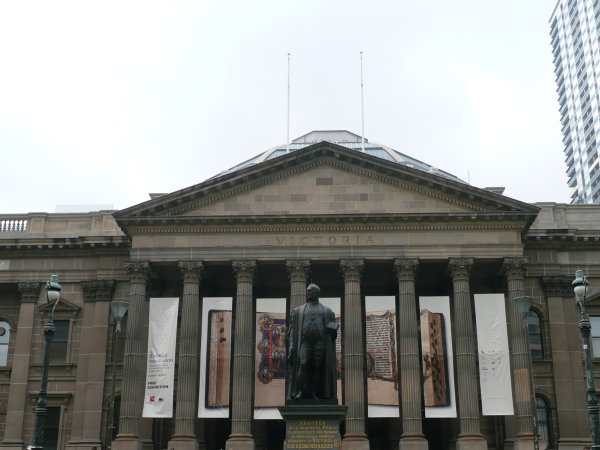

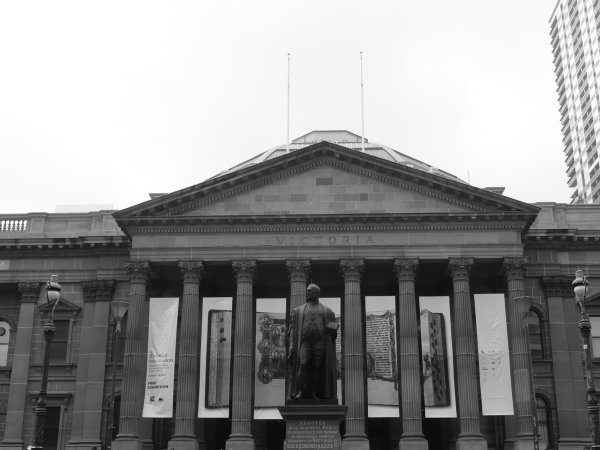

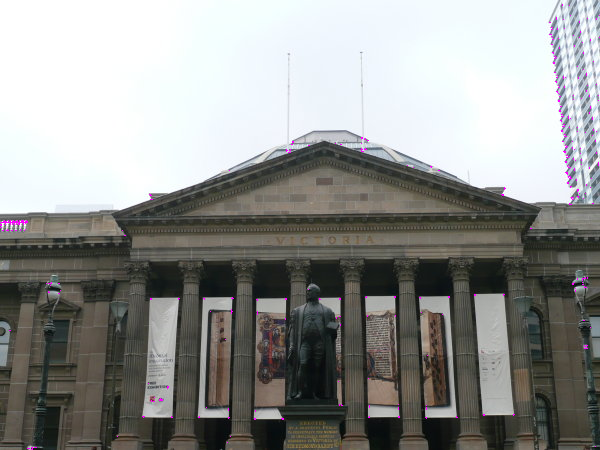

In [ ]:
"""
Image Warping + Blending
Save Panorama output as mypano.png
"""
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

im = image2.copy()
im2 = image1.copy()

# im = image2.copy()
# im2 = image3.copy()

inv_H_1_2 = np.linalg.inv(H_1_2)
inv_H_2_3 = np.linalg.inv(H_2_3)

panorama, offsetX, offsetY = combine_images(im2, H_1_2, im)
# panorama, offsetX, offsetY = combine_images(im2, inv_H_2_3, im)

#print("panorama", panorama.shape)
#print("y===", im.shape[0] + abs(offsetY))
#print("x===", im.shape[1] + abs(offsetX))

for y in range(abs(offsetY), im.shape[0] + abs(offsetY)):
    for x in range(abs(offsetX), im.shape[1] + abs(offsetX)):
        img2_y = y - abs(offsetY)
        img2_x = x - abs(offsetX)
        panorama[y, x, :] = im[img2_y, img2_x, :]

im2 = panorama


# Display
cv2_imshow(image1)
cv2_imshow(image1_grey)
# cv2_imshow(dst)
cv2_imshow(image1_corners)
# cv2_imshow(im2)
# cv2.waitKey(0)

# cv2.waitKey(0)      # Don't close the display window

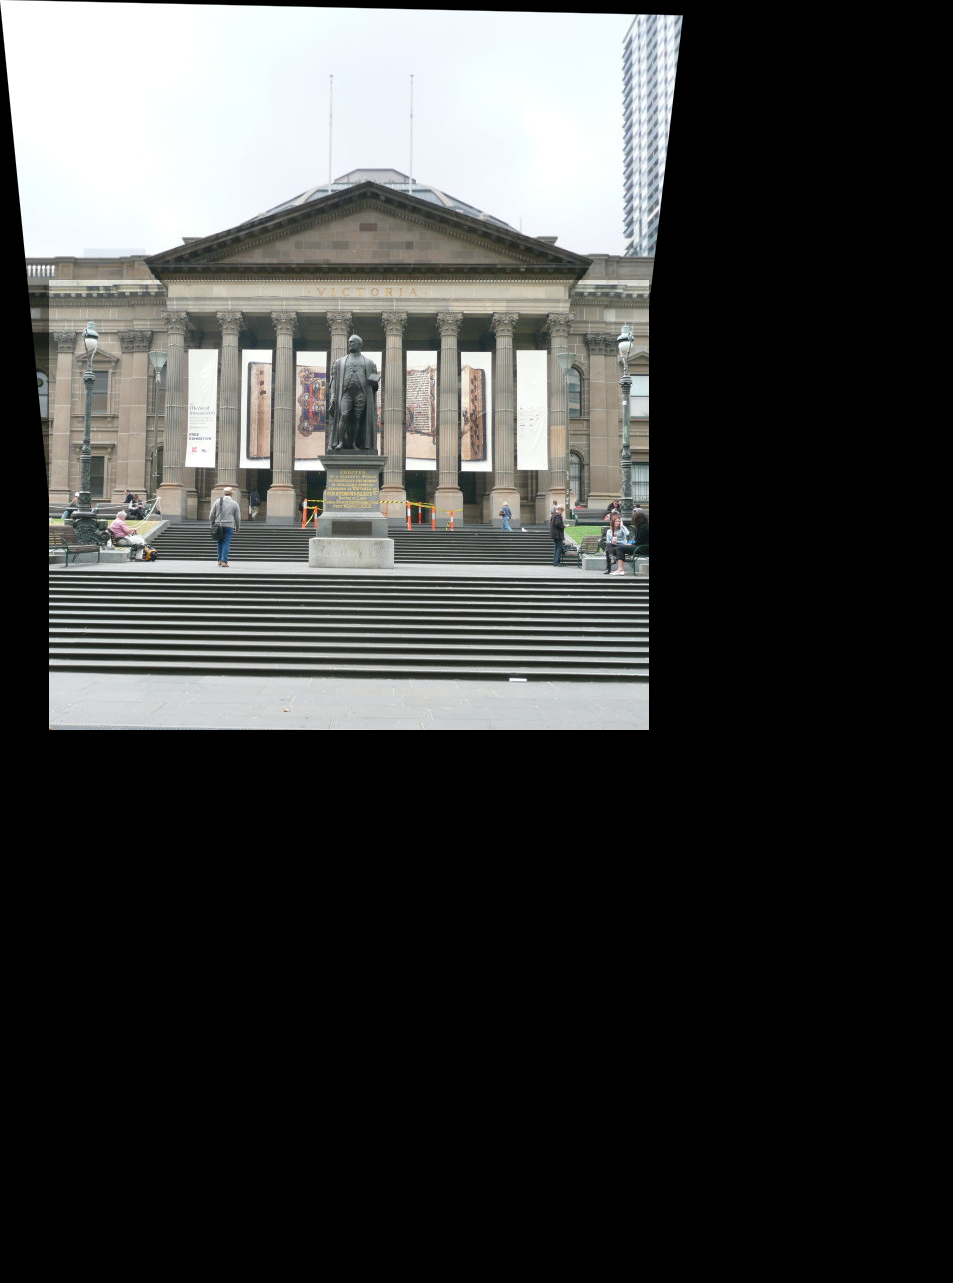

In [ ]:
cv2_imshow(im2)

In [ ]:
def main():
    # Add any Command Line arguments here
    # Parser = argparse.ArgumentParser()
    # Parser.add_argument('--NumFeatures', default=100, help='Number of best features to extract from each image, Default:100')

    # Args = Parser.parse_args()
    # NumFeatures = Args.NumFeatures

    """
    Read a set of images for Panorama stitching
    """

    im1_path = '../Data/Train/Set1/1.jpg'
    im2_path = '../Data/Train/Set1/2.jpg'
    im3_path = '../Data/Train/Set1/3.jpg'

    # im1_path = '../Data/Train/Set2/1.jpg'
    # im2_path = '../Data/Train/Set2/2.jpg'
    # im3_path = '../Data/Train/Set2/3.jpg'

    # im1_path = '../Data/Train/Set3/1.jpg'
    # im2_path = '../Data/Train/Set3/2.jpg'
    # im3_path = '../Data/Train/Set3/3.jpg'

    # im1_path = '../Data/Train/CustomSet1/custom1.jpg'
    # im2_path = '../Data/Train/CustomSet1/custom2.jpg'
    # im3_path = '../Data/Train/CustomSet1/custom3.jpg'

    image1 = cv2.imread(im1_path)                      # load from image file
    image2 = cv2.imread(im2_path)
    image3 = cv2.imread(im3_path)

    image1_grey = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)          # greyscale image, less data to work on
    # image1_grey = np.float32(image1_grey)                           # convert to numpy array
    image2_grey = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    # image2_grey = np.float32(image2_grey)
    image3_grey = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)

    """
    Corner Detection
    Save Corner detection output as corners.png
    """

    # Harris corner detector parameters
    block_size = 2      # neighborhood size
    k_size = 3          # aperture parameter for the Sobel operator
    k = 0.05            # Harris detector free parameter from the formula
    image1_dst = cv2.cornerHarris(image1_grey, block_size, k_size, k)
    image2_dst = cv2.cornerHarris(image2_grey, block_size, k_size, k)
    image3_dst = cv2.cornerHarris(image3_grey, block_size, k_size, k)

    # dst = cv2.dilate(dst, None)

    # Visualizing the corners, threshold for an optimal value depending on the image, higher is less sensitive
    tolerance = 0.04  # 0.04
    image1_corners = image1.copy()
    image2_corners = image2.copy()
    image3_corners = image3.copy()
    # Color the local maxima (identified corners) from the response map
    purple = [255, 0, 255]  # BGR values
    image1_corners[image1_dst > tolerance * image1_dst.max()] = purple
    image2_corners[image2_dst > tolerance * image2_dst.max()] = purple

    # TODO: save the output as corners.png

    """
    Perform ANMS: Adaptive Non-Maximal Suppression
    Save ANMS output as anms.png
    """
    num_best = 100
    image1_corners_best = ANMS(image1_corners, image1_dst, tolerance, num_best)
    image2_corners_best = ANMS(image2_corners, image2_dst, tolerance, num_best)
    image3_corners_best = ANMS(image3_corners, image3_dst, tolerance, num_best)

    # Display and save
    image1_ANMS = image1.copy()
    yellow = [0, 255, 255]
    dot_size = 3

    for corner in image1_corners_best:                                  # Visualizing the output
        x = int(corner[1])
        y = int(corner[0])
        cv2.circle(image1_ANMS, (x, y), dot_size, yellow, -1)
    # TODO save as anms.png
    # cv2.imwrite() ...


    """
    Feature Descriptors
    Save Feature Descriptor output as FD.png
    """
    image1_features = get_features(image1_corners_best, image1_grey)
    image2_features = get_features(image2_corners_best, image2_grey)
    image3_features = get_features(image3_corners_best, image3_grey)
    #print(image1_features.shape)

    """
    Feature Matching
    Save Feature Matching output as matching.png
    """

    matched_1_2 = match_features(image1_features, image2_features, image1_corners_best, image2_corners_best)
    matched_2_3 = match_features(image2_features, image3_features, image2_corners_best, image3_corners_best)

    # visualize_matches(image1, image2, matched)

    """
    Refine: RANSAC, Estimate Homography
    """
    H_1_2, matched_1_2 = RANSAC(matched_1_2)
    H_2_3, matched_2_3 = RANSAC(matched_2_3)

    visualize_matches(image1, image2, matched_1_2)
    visualize_matches(image2, image3, matched_2_3)

    """
    Image Warping + Blending
    Save Panorama output as mypano.png
    """
    im = image2.copy()
    im2 = image1.copy()

    # im = image2.copy()
    # im2 = image3.copy()

    inv_H_1_2 = np.linalg.inv(H_1_2)
    inv_H_2_3 = np.linalg.inv(H_2_3)

    panorama, offsetX, offsetY = combine_images(im2, H_1_2, im)
    # panorama, offsetX, offsetY = combine_images(im2, inv_H_2_3, im)

    #print("panorama", panorama.shape)
    #print("y===", im.shape[0] + abs(offsetY))
    #print("x===", im.shape[1] + abs(offsetX))

    for y in range(abs(offsetY), im.shape[0] + abs(offsetY)):
        for x in range(abs(offsetX), im.shape[1] + abs(offsetX)):
            img2_y = y - abs(offsetY)
            img2_x = x - abs(offsetX)
            panorama[y, x, :] = im[img2_y, img2_x, :]

    im2 = panorama


    # Display
    #cv2.imshow('Image window', image1)
    # cv2.imshow('Image window2', image1_grey)
    # cv2.imshow('Image window2', dst)
    # cv2.imshow('Image window2', image1_corners)
    cv2.imshow('Image window2', im2)
    # cv2.waitKey(0)      # Don't close the display window



PHASE-2 Starts




Panorama created successfully!


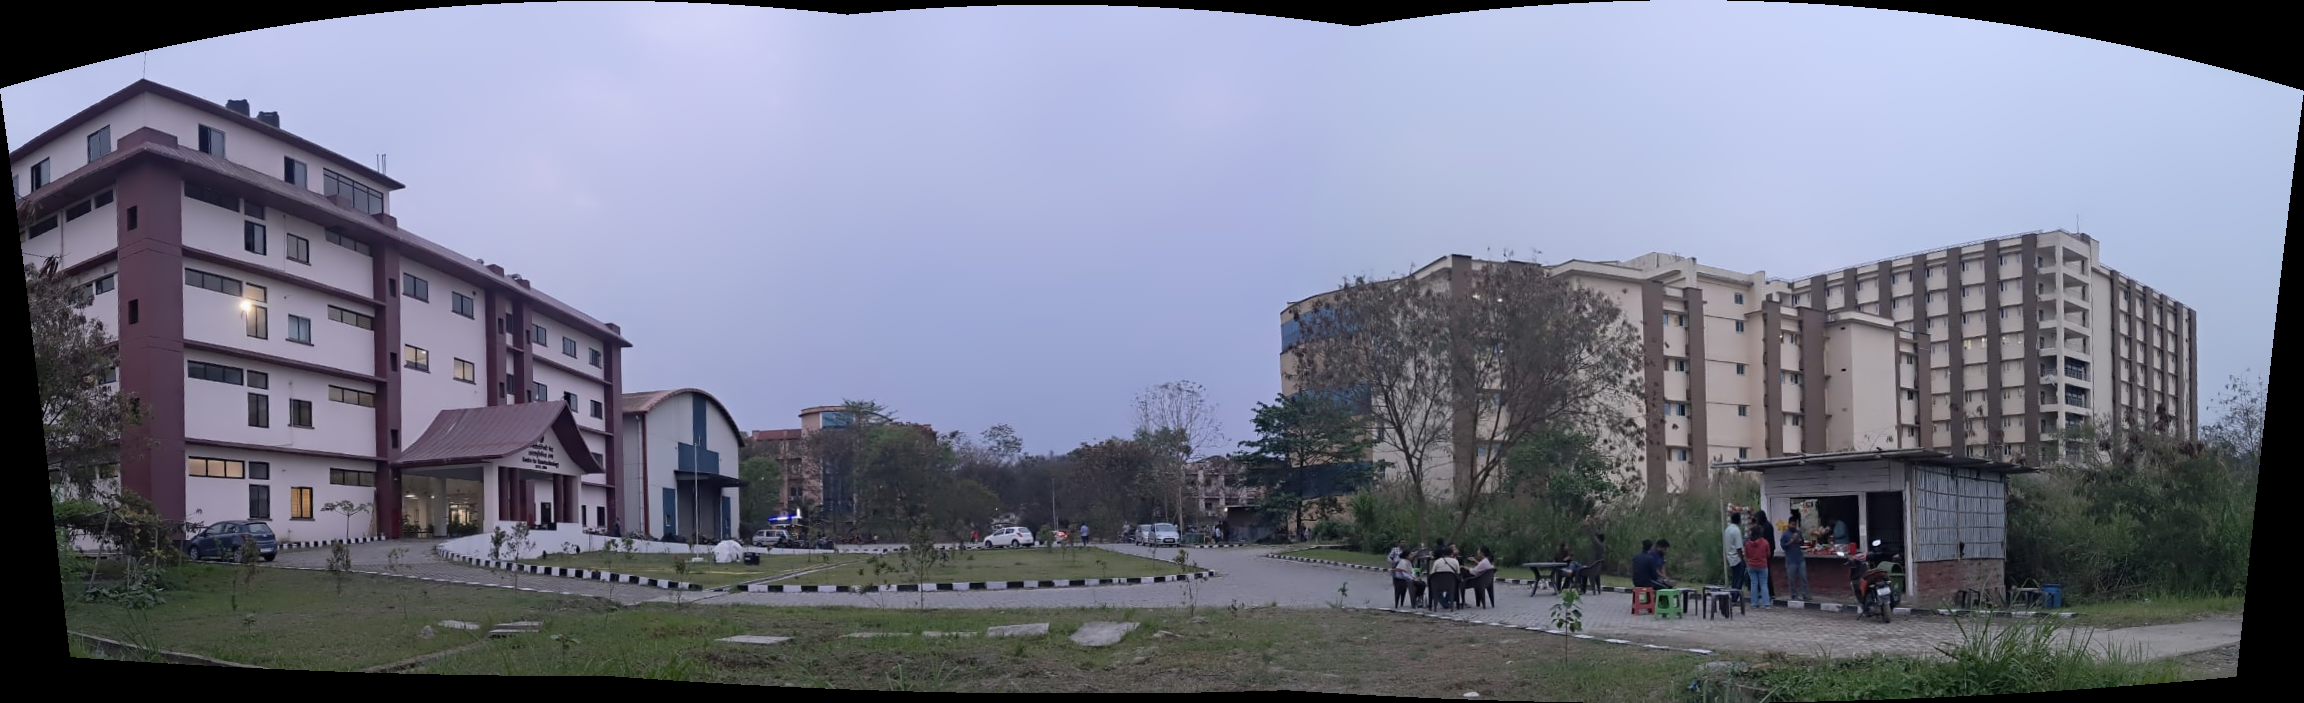

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
def stitch_images(image1_path, image2_path, image3_path):
    # Read images
    image1 = cv2.imread("/content/mage1.jpeg")
    image2 = cv2.imread("/content/mage2.jpeg")
    image3 = cv2.imread("/content/mage3.jpeg")

    # Initialize the stitcher
    stitcher = cv2.Stitcher_create()

    # Stitch images
    status, stitched_image = stitcher.stitch((image1, image2, image3))

    if status == cv2.Stitcher_OK:
        return stitched_image
    else:
        print("Stitching failed!")
        return None

# Example usage
image1_path = "/content/mage1.jpeg"  # Change this to the path of your first image
image2_path = "/content/mage2.jpeg"  # Change this to the path of your second image
image3_path = "/content/mage3.jpeg"  # Change this to the path of your third image

stitched_image = stitch_images(image1_path, image2_path, image3_path)

if stitched_image is not None:
    cv2.imwrite("panorama.jpg", stitched_image)  # Save the stitched image
    print("Panorama created successfully!")
    cv2_imshow(stitched_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Failed to create panorama.")
